# How the ENU_407.py module works

The `enu_407.py` module contains functions that allow you to focus on science rather than python.

## ENU coordinates

The ENU coordinate system refers to the convention that $x=east, y=north, z=up$.  
<img src="ENU_coordinates.jpg" align="left" width=250/>  

In [1]:
import numpy as np
np.set_printoptions(suppress=True, precision=6, floatmode='fixed')

import matplotlib.pyplot as plt

import enu_407 as enu

## Lines and planes

Functions are provided that convert observations of planes (strike,dip) and lines (plunge,trend) into unit direction vectors.  
For a plane, the direction is perpendicular (normal) to the plane.  
Try experimenting with some different orientations to build intuition.  
  
We are using arrays of vectors **$v_i$** $=[x_i,y_i,z_i]$ with structure something like  
`[[x0,x1,x2,...xn],
  [y0,y1,y2,...yn],
  [z0,z1,z2,...zn]]`  
i.e. we organize the vectors as columns.

In [2]:
# create lists (array-like) of values
plunge = [1,89,1,89]
trend = [1,1,181,181]
vLines = enu.dirVecLine(plunge,trend)
print("Column vectors for lines:\n", vLines,"\n")

strike = [0,0,0,0]
dip = [90,60,30,0]
vPlane = enu.dirVecPlane(strike,dip)
print("Column vectors for planes:\n", vPlane)


Column vectors for lines:
 [[ 0.017450  0.000305 -0.017450 -0.000305]
 [ 0.999695  0.017450 -0.999695 -0.017450]
 [-0.017452 -0.999848 -0.017452 -0.999848]] 

Column vectors for planes:
 [[ 1.000000  0.866025  0.500000  0.000000]
 [ 0.000000  0.000000  0.000000  0.000000]
 [-0.000000  0.500000  0.866025  1.000000]]


## Vector utilities
 
It is convenient to have functions that manage basic operations such as magnitude (length) and dot product.  
  
Consider two vectors  
**u** $=[u_x,u_y,u_z]$, **v** $=[v_x,v_y,v_z]$

### Magnitude 
The magnitude of a vector is simply its length.    
|**u**| $=\sqrt{u_x^2 + u_y^2 + u_z^2}$  
Direction vectors have unit length.  

### Dot product
The dot product between two vectors is the product of the lengths projected onto either vector.  
  
**u**$\cdot$**v** $=u_x v_x + u_y v_y + u_z v_z =$ |**u**| |**v**| $cos\theta$  

<img src="dot-product.jpg" align="inline" width=150/>   
  
  
  
For unit vectors, |**u**| $=$ |**v**| $=1$, it is a convenient way to find the cosine of the angle between the two directions.

In [3]:
# the lengths should all be 1
print(enu.vecMagnitude(vLines))

# dot products depend on angles between the vectors
print(enu.vecDotProduct(vLines,vPlane))

[1.000000 1.000000 1.000000 1.000000]
[ 0.017450 -0.499660 -0.023839 -0.999848]


## 3D stress tensor
The function `makeStressTensor(SHmin,SHmax,SV,azimuth_SHmax)` returns a 3x3 matrix (stress tensor), given the principal stress magnitudes and azimuth of the maximum horizontal principal stress.  

It does it by first constructing a diagonal matrix using `stressTensorDiagonal(sigma_E, sigma_N, sigma_U)` and then rotating it about a vertical axis using `rotationMatrixAroundZ(angle)`.

**Example.** A reverse-faulting regime at 4 km depth.  
$\sigma_v = \sigma_3 = 67$ MPa, $\sigma_2 = 190$ MPa, $\sigma_1 = 312$ MPa.  
The azimuth of SHmax is 090&deg;, i.e. due east.  

<img src="MohrGraphPaper3-pexam-A-ANSWER.jpg" align="inline" width=700/>   
  
Experiment to build intuition with what a stress tensor looks like.

In [4]:
SV = 67.0
SHmin = 190.0
SHmax = 312.0
azimuth_SHmax = 90.0

stressTensor = enu.makeStressTensor(SHmin,SHmax,SV,azimuth_SHmax)

print(stressTensor)

[[312.000000   0.000000   0.000000]
 [  0.000000 190.000000   0.000000]
 [  0.000000   0.000000  67.000000]]


## Tractions and failure  
The stress tensor **S** is used to calculate the traction vector **T** on a plane defined by normal vector **n**.      

<img src="StressOnPlane2.jpg" align="inline" width=120/>   

**T** $=$ **S** $\cdot$ **n**  
The normal stress magnitude $\sigma_N = $**T** $\cdot$ **n**   
The shear stress vector $\boldsymbol{\tau} =$ **T** $- \sigma_N$ **n**  
The shear stress magnitude = |$\boldsymbol{\tau}$|

### Coulomb failure criterion
For completeness a function returning the Coulomb failure criterion for given parameters and normal stress is also provided.  


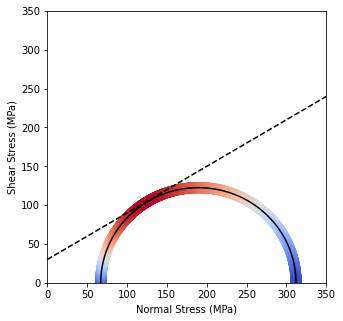

In [9]:
# Failure criterion
cohesion = 30.0
coefficientFriction = 0.6
normalStressAll = np.linspace(0,350,2000)
shearStrengthAll = enu.strengthCoulomb(cohesion,coefficientFriction,normalStressAll)

# Use stress tensor above
# for E-W stress state draw Mohr circle
azimuth = 0.0
strike = np.ones(1000) * azimuth
dip = np.linspace(0,90,1000)
planes = enu.dirVecPlane(strike,dip)
normalStress,shearStress = enu.stressOnPlane(stressTensor,planes)
shearStrength = enu.strengthCoulomb(cohesion,coefficientFriction,normalStress)
slipTendency = shearStress / shearStrength

# Plot
plt.figure(figsize=[5,5])
plt.scatter(normalStress,shearStress,
            c=slipTendency,cmap='coolwarm',s=100)
plt.plot(normalStress,shearStress,c='black')
plt.plot(normalStressAll,shearStrengthAll,
         color='black',linestyle='--')
plt.xlim([0,350])
plt.ylim([0,350])
plt.xlabel('Normal Stress (MPa)')
plt.ylabel('Shear Stress (MPa)')
plt.savefig('../figs/mohrDiagram.jpg',dpi=300)
plt.show()